In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.transform import resize


# Define the forward diffusion process
def forward_diffusion(image, timesteps, beta_min=0.0001, beta_max=0.02):
    """
    Add noise to the image over timesteps following a diffusion schedule.
    """
    betas = np.linspace(beta_min, beta_max, timesteps)  # Linear schedule
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    
    noised_images = []
    for t in range(timesteps):
        noise = np.random.normal(0, 1, image.shape)
        noised_image = np.sqrt(alphas_cumprod[t]) * image + np.sqrt(1 - alphas_cumprod[t]) * noise
        noised_images.append(noised_image)
    
    return noised_images, alphas_cumprod


# Visualization of the forward process
def visualize_forward_process(image, noised_images, timesteps_to_show):
    """
    Visualize the progression of the forward diffusion process.
    """
    plt.figure(figsize=(15, 5))
    for i, t in enumerate(timesteps_to_show):
        plt.subplot(1, len(timesteps_to_show), i + 1)
        plt.imshow(np.clip(noised_images[t], 0, 1))
        plt.title(f"Step {t}")
        plt.axis("off")
    plt.show()


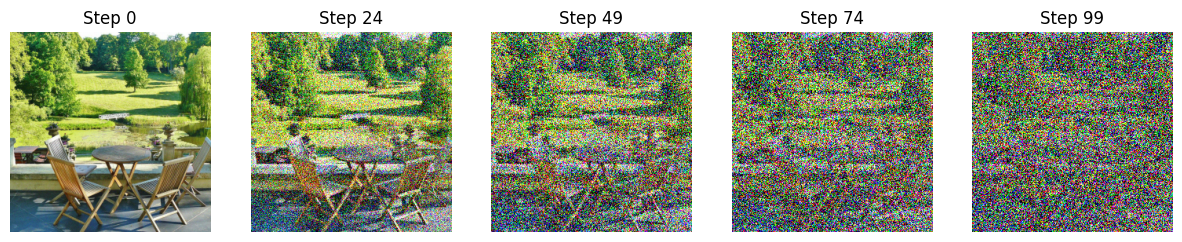

In [16]:
from PIL import Image

image = Image.open("images/castle-park.jpg")
image = np.asarray(image)
image = resize(image, (256, 256), anti_aliasing=True)

timesteps = 100  # Number of diffusion steps
noised_images, alphas_cumprod = forward_diffusion(image, timesteps)

# Visualize forward process
timesteps_to_show = [0, 24, 49, 74, 99]  # Example timesteps to show
visualize_forward_process(image, noised_images, timesteps_to_show)

